# Analyse du dataset 1

Après l'analyse réalisée dans le notebook 02, nous avons remarqué que toutes les images du dataset 1 sont des factures en niveaux de gris et de même taille.  
Le but de ce notebook est donc de récupérer les fréquences des mots qui caractérisent cette catégorie d'images.


In [1]:
import os
current_dir = %pwd
project_dir = os.path.dirname(current_dir)
%cd $project_dir

c:\Users\Bryan Fernandez\Desktop\DataScientest\doc-classifier


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

C:\Users\Bryan Fernandez\AppData\Local\Temp\ipykernel_88888\2990391754.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Nous n'avons pas besoin de réaliser d'océrisation pour ce dataset car elle a déjà été réalisée. Les résultats se trouvent dans le dossier ocr dans des fichiers .xml avec la structure suivante :

$\;$\<TextRegion>  
$\;\;\;\;\;\;$\<TextLine>  
$\;\;\;\;\;\;\;\;\;\;$\<Word>  
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$\<Unicode> TEXT \</Unicode>  
$\;\;\;\;\;\;\;\;\;\;$\</Word>  
$\;\;\;\;\;\;$\</TextLine>  
$\;$\</TextRegion>

Le text se trouve dans l'attribut \<Unicode>


In [3]:
# Chemin du dataset
file_path = "data/raw/data_01/ocr"

# Récupération de la liste des noms de fichiers dans le dossier
list_filename = os.listdir(file_path)

Après avoir étudié un exemple de XML, nous avons remarqué la présence de l'attribut **"language"**. Nous avons extrait la langue du texte pour chaque image.


In [4]:
from src import img_xml_language

img_xml_language(list_filename, file_path)

['en-US']


Nous n'avons que la valeur **"en_US"** nous présumons qu'il s'agit de la langue anglaise. Cependant, nous avons créé une fonction permettant de détecter la langue à partir de la bibliothèque spaCy.

Nous avons dans un premier temps initialisé un tokenizer. En utilisant la classe RegexpTokenizer du module nltk.tokenize, on instancie une expression régulière qui sera utilisée pour définir comment le texte devrait être divisé en tokens lors de l'analyse.


In [5]:
from nltk.tokenize.regexp import RegexpTokenizer

tokenizer = RegexpTokenizer("[a-zA-ZéèàïôêûçëüÉÈÀÏÔÊÛÇËÜ]{3,}")

Pour cette partie, nous allons profiter du fait que l'on analyse les images une par une pour construire le fichier "text_process.csv" qui nous servira pour la suite du projet.

Les étapes pour avoir la langue par image sont les suivantes :

- Récupérer le text de l'attribuut \<Unicode> à l'aide de la fonction img_xml_unicode()
- Diviser le text en mots(tokens)
- Détecter la langue avec la fonction detect_lang()


In [6]:
# Environ 10 min

from src import img_xml_unicode
from src import detect_lang
from src import lemmatize_english, lemmatize_french
from src import stop_words_filtering

df_ocr = pd.DataFrame(
    columns=['words', 'lang', 'lang_score', 'file_name', 'category'])


for xml_file in list_filename:

    # Détection de la langue
    words = img_xml_unicode(xml_file, file_path).lower()
    tokens = tokenizer.tokenize(words.lower())
    lang = detect_lang(tokens)

    # Pour la construction du fichier text_process.csv
    file_name = xml_file[:-4]

    if lang['language'] == 'fr' and lang['score'] > 0.5:
        words_filter = stop_words_filtering(tokens, 'french')
        lemmatized_tokens = lemmatize_french(words_filter)
    else:
        words_filter = stop_words_filtering(tokens, 'english')
        lemmatized_tokens = lemmatize_english(words_filter)

    lemmatized_tokens = ' '.join(lemmatized_tokens)

    new_row = {'words': lemmatized_tokens,
               'lang': lang['language'], 'lang_score': lang['score'], 'file_name': file_name, 'category': 'invoice'}
    df_ocr.loc[len(df_ocr)] = new_row

df_ocr.to_csv('data/raw/data_01/text_process.csv', index=False)

df_ocr.head()

,words,lang,lang_score,file_name,category
0,center indoor air research winteraon road suit...,en,0.999996,image_0000000,invoice
1,box kansas city missouri coo claire carcich ph...,en,0.999995,image_0000001,invoice
2,march attention statement chargo professor ste...,en,0.999995,image_0000002,invoice
3,ge von ahlendorf iiarat peter ahlendorf gmbh s...,de,0.999996,image_0000003,invoice
4,send rjr orsyth orsytli tcbaccc gwen scott com...,en,0.999995,image_0000004,invoice


Nous avons retiré les "mots vides" (_stop words_) de notre variable pour les fichiers en englais et français. Puis Nous avons effectué une lemmatisation afin de normaliser le texte et réduire le vocabulaire à sa forme la plus fondamentale (forme dans le dictionnaire) dans la langue souhaitée.


In [7]:
df_ocr['lang'].unique()

array(['en', 'de', 'fr', 'nl', 'ca', 'sv', 'UNKNOWN'], dtype=object)

On remarque que nous avons des fichiers dans d'autres langues.


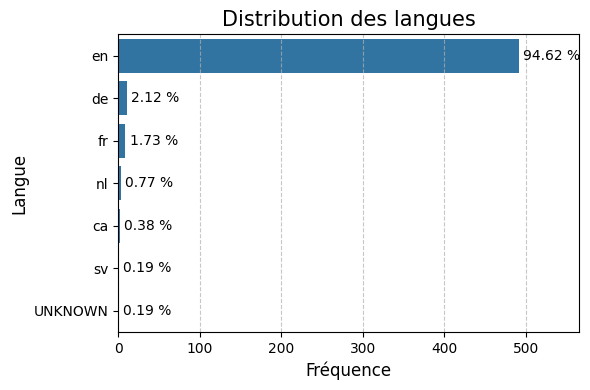

In [8]:
from src import barplot

count = df_ocr['lang'].value_counts()
barplot(x=count.values,
        y=count.index,
        figsize=(6, 4),
        xlabel='Fréquence',
        ylabel='Langue',
        title=f'Distribution des langues')

Etant donné que la langue "en"(anglais) est à plus de 94%, nous décidons de supprimer les autres lignes.


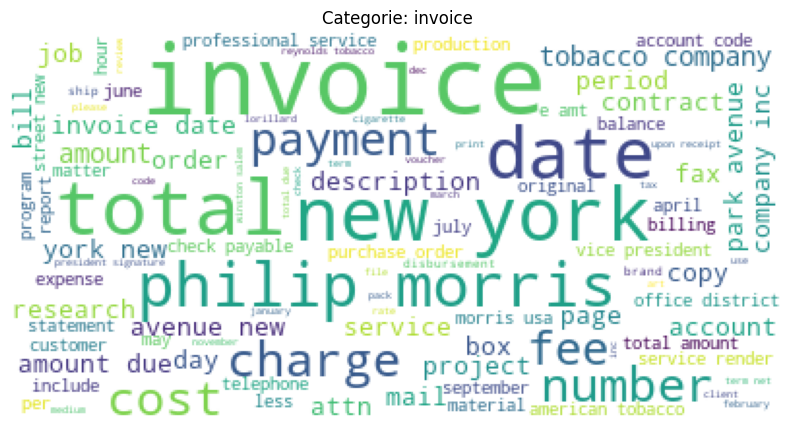

In [9]:
from src import create_wordcloud

df_ocr = df_ocr[df_ocr['lang'] == 'en']
df_ocr['words'] = df_ocr['words'].apply(
    lambda x: x.split(' ') if isinstance(x, str) else [])
en_words = df_ocr['words'].sum()

create_wordcloud(en_words, title="Categorie: invoice")

Ce WordCloud nous permet de voir en un coup d'oeil les mots fréquents dans notre texte. Pour mieux voir quels mots sont les plus fréquents dans notre jeu de données nous réalisons un diagramme en bar.


In [10]:
from collections import Counter

word_freq = Counter(en_words)

top_20_words = word_freq.most_common(20)

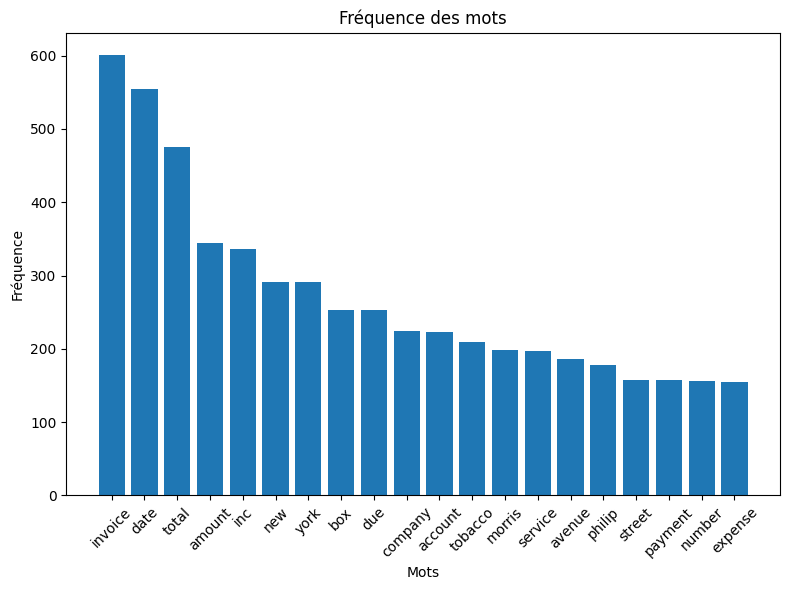

In [11]:
words, frequencies = zip(*top_20_words)

plt.figure(figsize=(8, 6))
plt.bar(words, frequencies)
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.title('Fréquence des mots')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()